# XGBoost to predict discharge disability


Using all features, with a 5-fold cross validation, using the model trained in notebook 010: a multiclass classification model to give the probability (likelihood) that each patient is in each discharge disability class (mRS 0, 1, 2, 3, 4, 5 or 6)
Examine the consistency of the patterns that the model identifies across 5 k-folds, specifically in terms of feature importance and SHAP.

## Plain English summary
Does the output for the patents probability for each mRS output change linearly across the mRS levels? Investigate this for all patients in k-fold 1.

## Model and data
XGBoost All the features

## Aims
Look at the global patterns using SHAP for the instances in the first kfold split.

## Observations
Found it interesting that the output for the patents probability for each mRS output did not change linearly across the mRS levels.

Investigate if this is true for all patients.

Observations
* There are 21359 patients with 0 inflection points on the graph (13.6%)
* There are 47081 patients with 1 inflection points on the graph (30.0%)
* There are 70871 patients with 2 inflection points on the graph (45.2%)
* There are 7405 patients with 3 inflection points on the graph (4.7%)
* There are 9966 patients with 4 inflection points on the graph (6.4%)
* There are 165 patients with 5 inflection points on the graph (0.1%)

* Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point): 68440 patients (43.6%)
* Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale: 88407 patients (56.4)%

* These proportions are not different between the cohort of patients that are correctly (vs incorrectly) classified.

## Further work
How does the probability for the multiclass levels change across the mRS classes? Is it consitently incresing and decreasing up to and away from the predicted class?

## Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

(code orignially from 01a_xgb_kfold_all_features_accuracy_importance_shap.ipynb and 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb)


(based on notebook 01b_xgb_kfold_all_features_multiclass_probability_pattern.ipynb: Taking copy of 230623 (training model with default learning rate of 0.3, using onset to thrombolysis, using -100 when not have thrombolysis)

## Import libraries

In [89]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import math

import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass

import pickle

from os.path import exists

import time

Report the time duration to run notebook

In [3]:
start_time = time.time()

Choose the singl kfold split to use

In [4]:
k = 0

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_all_features_kfold{k}'
    notebook: str = '014_'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

Some features need to be removed from the dataset (those that are duplicates). Define a function to do this.

In [7]:
def drop_columns(df, cols):
    for col in cols:
        if col in df.columns: df.drop([col],axis=1,inplace=True)
    return(df)

Specify the columns to remove

In [8]:
cols_remove = ['id','stroke_team_id']

## Import data
Data has previously been split into 5 stratified k-fold splits. Read these in.

In [9]:
# Read in training set, restrict to chosen features
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train_data = pd.read_csv(filename)
train_data = drop_columns(train_data, cols_remove)

# Read in training set, restrict to chosen features
filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test_data = pd.read_csv(filename)
test_data = drop_columns(test_data, cols_remove)

In [10]:
class_names = train_data['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

In [11]:
n_patients = test_data.shape[0]

## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [12]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [13]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, convert to one hot encoded

In [14]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    train_data = convert_feature_to_one_hot(train_data, feature, prefix)
    test_data = convert_feature_to_one_hot(test_data, feature, prefix)

Get X and y

In [15]:
X_train = train_data.drop('discharge_disability', axis=1)
X_test = test_data.drop('discharge_disability', axis=1)
y_train = train_data['discharge_disability']
y_test = test_data['discharge_disability']

## Load XGBoost model

Get probabilities of each mRS score for each patient.

In [17]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                        ('010_xgb_all_features_5fold_' + str(k) + '.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    print('Run notebook 010 first. Using the model that was trained there')

# Get target categories from model
classes = model.classes_

# Get predicted probabilities
y_probs = model.predict_proba(X_test)

# Get predicted class
y_pred = model.predict(X_test)

Per patient, have the probability of being each mRS label.

Interested whether the probability is linear across the mRS levels, or whether there are some up and downs.

View the probabilities of the multiclassification for the first patient

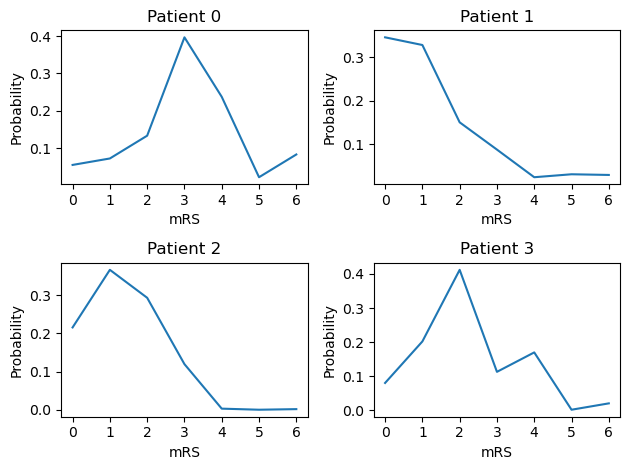

In [42]:
fig, axes = plt.subplots(2,2)
axes = axes.ravel()
for p in range(4):
    axes[p].plot([0,1,2,3,4,5,6],y_probs[p,:])
    axes[p].set_title(f"Patient {p}")
    axes[p].set_xticks(np.arange(0, 7, 1))
    axes[p].set_xlabel("mRS")
    axes[p].set_ylabel("Probability")
plt.tight_layout()
plt.show()


For all patients, calculate the number of inflection points.

A point of inflection is where the graph of a function changes concavity. This is where the second derivative of function changes sign (from negative to positive, or vice-versa).

If a function has 0 or 1 inflection points, then the probability of the mRS has at most a single change, and so falls linearly around the highest point.

If a function has 2 or more inflection points, then the probabiliy changes more randomly across the mRS levels.

My initial appraoch was to use the second derivative, but took a more first principles approach - around each point see whether the neighbouring points made it an inflection).

Set a buffer value so that this needs to be exceeded to be classified as a change in direction. Such as, an inflection only counted if change in probability is >0.01 (1%)

In [34]:
# Set the min difference that qualifies as a change in direction
buffer = 0.01

# Initialise a series to store the number of inflections per patient
n_inflection_points = pd.Series(0, index=np.arange(n_patients), 
                                name='n_inflections')

for c in range(1,6):
    mask_hill = ((y_probs[:,c-1] - y_probs[:,c] > buffer) & 
                 (y_probs[:,c] - y_probs[:,c+1]<-buffer))
    mask_trough = ((y_probs[:,c-1] - y_probs[:,c] < -buffer) & 
                   (y_probs[:,c] - y_probs[:,c+1]>buffer))

    n_inflection_points = n_inflection_points + mask_hill + mask_trough

print (f"Number of inflections per patient (for first five patients), using "
       f"buffer {buffer} probability")
n_inflection_points[:5]

Number of inflections per patient (for first five patients), using buffer 0.01 probability


0    2
1    0
2    1
3    4
4    0
Name: n_inflections, dtype: int64

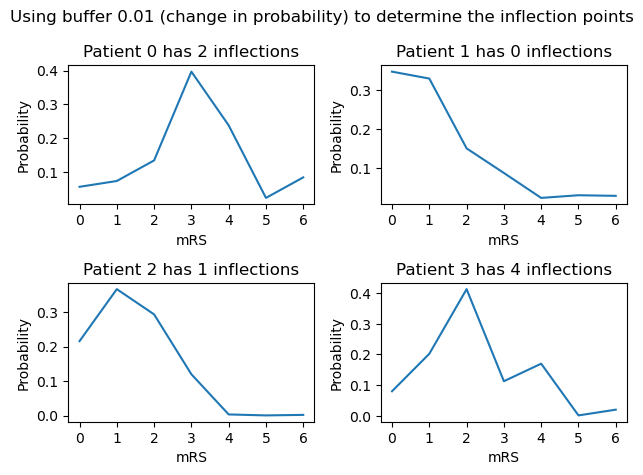

In [40]:
fig, axes = plt.subplots(2,2)
fig.suptitle(f"Using buffer {buffer} (change in probability) to determine the inflection points")
axes = axes.ravel()
for p in range(4):
    axes[p].plot([0,1,2,3,4,5,6],y_probs[p,:])
    axes[p].set_title(f"Patient {p} has {n_inflection_points[p]} inflections")
    axes[p].set_xticks(np.arange(0, 7, 1))
    axes[p].set_xlabel("mRS")
    axes[p].set_ylabel("Probability")
plt.tight_layout()
plt.show()

Report an overview of number of patients with each number of inflection points.

In [52]:
def results_overview(n_inflection_points):
    list_patients_correct = []
    n_patients = n_inflection_points.shape[0]
    for i in range(6):
        x = (n_inflection_points == i).sum()
        print (f"There are {x} patients with {i} "
            f"inflection points on the graph ({round(x/n_patients,3)*100}%)")
        list_patients_correct.append(x)
    print()

    x = (n_inflection_points <2).sum()
    print (f"Having 1 or fewer inflection points means that the mRS probabilities "
        f"are linear (maybe around a mid point). "
        f"({x} patients ({round(x/n_patients,3)*100}%)")
    x = (n_inflection_points >1).sum()
    print(f"Having more that 1 inflection point means that the mRS probabilities "
        f"go up and down across the full mRS scale. "
        f"({x} patients ({round(x/n_patients,3)*100})%")
    return(list_patients_correct)

In [53]:
results_overview(n_inflection_points)

There are 4567 patients with 0 inflection points on the graph (13.600000000000001%)
There are 12273 patients with 1 inflection points on the graph (36.5%)
There are 11733 patients with 2 inflection points on the graph (34.8%)
There are 2475 patients with 3 inflection points on the graph (7.3999999999999995%)
There are 2523 patients with 4 inflection points on the graph (7.5%)
There are 99 patients with 5 inflection points on the graph (0.3%)

Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point). (16840 patients (50.0%)
Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale. (16830 patients (50.0)%


[4567, 12273, 11733, 2475, 2523, 99]

How about if look at the patients that are correctly predicted, versus those not. Is the model more certain for the ones that it got correct?

In [54]:
mask_correct = y_pred == y_test
patients_correct = mask_correct.sum()
print(f"{patients_correct} patients are correctly classified "
      f"({round(patients_correct/n_patients,3)*100}%)")
list_patients_correct = results_overview(n_inflection_points[mask_correct])
print()

mask_incorrect = y_pred != y_test
patients_incorrect = mask_incorrect.sum()
print(f"{patients_incorrect} patients incorrectly classified "
      f"({round(patients_incorrect/n_patients,3)*100}%))")

list_patients_incorrect = results_overview(n_inflection_points[mask_incorrect])

14811 patients are correctly classified (44.0%)
There are 2510 patients with 0 inflection points on the graph (16.900000000000002%)
There are 5802 patients with 1 inflection points on the graph (39.2%)
There are 4774 patients with 2 inflection points on the graph (32.2%)
There are 867 patients with 3 inflection points on the graph (5.8999999999999995%)
There are 830 patients with 4 inflection points on the graph (5.6000000000000005%)
There are 28 patients with 5 inflection points on the graph (0.2%)

Having 1 or fewer inflection points means that the mRS probabilities are linear (maybe around a mid point). (8312 patients (56.10000000000001%)
Having more that 1 inflection point means that the mRS probabilities go up and down across the full mRS scale. (6499 patients (43.9)%

18859 patients incorrectly classified (56.00000000000001%))
There are 2057 patients with 0 inflection points on the graph (10.9%)
There are 6471 patients with 1 inflection points on the graph (34.300000000000004%)
T

Create a nested pie chart

https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/nested_pie.html#sphx-glr-gallery-pie-and-polar-charts-nested-pie-py

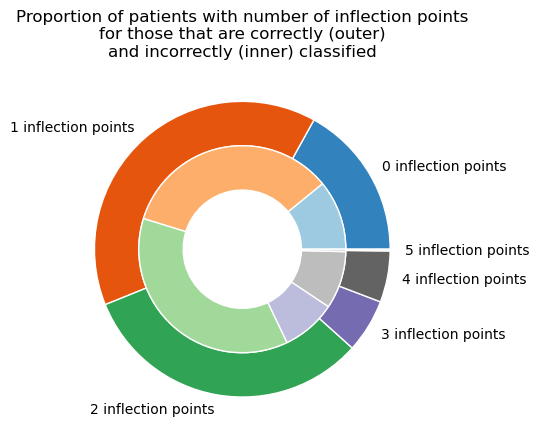

In [109]:
fig, ax = plt.subplots()

size = 0.3

max_infection_points = max(len(list_patients_correct), len(list_patients_incorrect))
labels = [(str(i) + " inflection points")for i in range(max_infection_points)]
list_data = [list_patients_correct, list_patients_incorrect]
list_titles = ["Patients correctly classified", "Patients incorrectly classified"]

cmap = plt.get_cmap("tab20c")
colour_array = np.arange(max_infection_points)
outer_colors = cmap(colour_array * 4)
inner_colors = cmap(colour_array * 4 + 2)


ax.pie(list_data[0], radius=1, colors=outer_colors, labels=labels,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(list_data[1], radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", 
       title=('Proportion of patients with number of inflection points\nfor '
              'those that are correctly (outer)\nand incorrectly (inner) classified'))
plt.show()

Try and improve the colour selection, as otherwise no colour is selected for 5 inflection points.

In [90]:
def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)


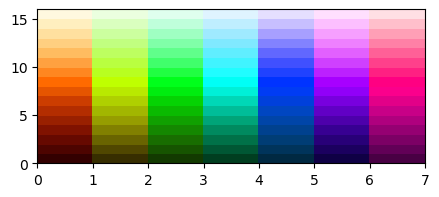

In [94]:
N = 16
M = 7
H = np.arange(N*M).reshape([N,M])
fig = plt.figure(figsize=(5, 2))
ax = plt.pcolor(H, cmap=generate_colormap(N*M))
plt.show()

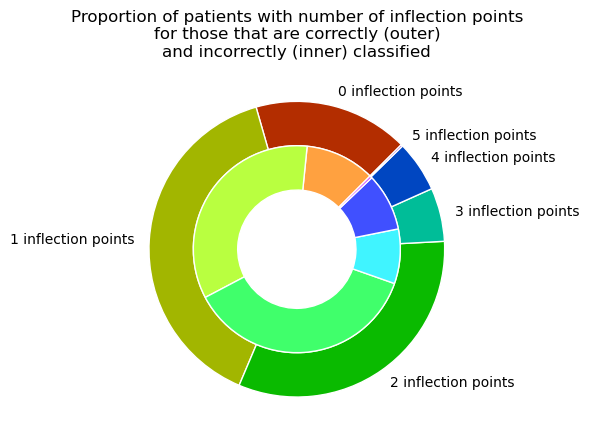

In [125]:
fig, ax = plt.subplots()

size = 0.3

max_infection_points = max(len(list_patients_correct), len(list_patients_incorrect))
labels = [(str(i) + " inflection points")for i in range(max_infection_points)]
list_data = [list_patients_correct, list_patients_incorrect]
list_titles = ["Patients correctly classified", "Patients incorrectly classified"]

N = 16
M = 7
cmap = generate_colormap(N*M)
colour_array = np.arange(max_infection_points)
outer_colors = cmap(colour_array + (M * 5))
inner_colors = cmap(colour_array + (M * 10))

ax.pie(list_data[0], radius=1, colors=outer_colors, startangle=45, 
       labels=labels, wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(list_data[1], radius=1-size, colors=inner_colors, startangle=45,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", 
       title=('Proportion of patients with number of inflection points\nfor '
              'those that are correctly (outer)\nand incorrectly (inner) classified'))
plt.show()